In [1]:
import sys
sys.path.insert(0, './pyLDLE2/')

In [2]:
import numpy as np
from pyLDLE2 import visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from scipy.sparse.linalg import eigsh
from scipy.stats import chi2
from sklearn.decomposition import PCA

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [3]:
vis = visualize_.Visualize()

In [20]:
X, labelsMat, ddX = datasets.Datasets().circular_disk_uniform(n=10000, noise=0.0, noise_type='uniform')
X_noise, _, ddX_noise = datasets.Datasets().circular_disk_uniform(n=10000, noise=0.05, noise_type='uniform')

X.shape =  (7837, 2)
X.shape =  (7837, 3)


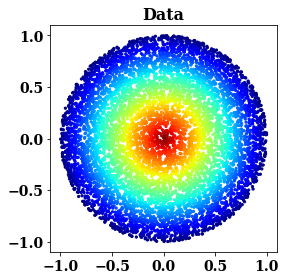

In [21]:
vis.data(X, ddX)

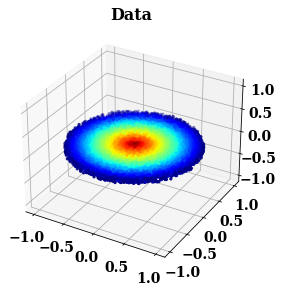

In [22]:
vis.data(X_noise, ddX_noise)

In [23]:
from graphlearning import weightmatrix
from graphlearning import graph
def boundary_statistic(X, r, knn=False, 
                       return_normals=False, 
                       second_order=True, 
                       cutoff=True, 
                       knn_data=None,
                       ds=False):
    """Boundary test statistic
    ===================

    Computes the boundary test statistics from [1] for identifying the boundary of a point cloud.
    J. Calder, S. Park, and D. Slepčev. [Boundary Estimation from Point Clouds: Algorithms, Guarantees and Applications.](https://arxiv.org/abs/2111.03217) arXiv:2111.03217, 2021.
    """

    #Estimation of normal vectors
    n = X.shape[0]
    d = X.shape[1]
    if knn:
        k = r
        #Run knnsearch only if knn_data is not provided
        if knn_data is None:
            J,D = weightmatrix.knnsearch(X,k)
        else:
            J,D = knn_data
        W = weightmatrix.knn(X, k, kernel='uniform', symmetrize=False, knn_data=(J,D))
    else:
        W = weightmatrix.epsilon_ball(X, r, kernel='uniform')
    W_old = W.copy()
    if ds:
        W = W.tocoo()
        W, _ = sinkhorn(W)
        W = W.tocsr()
        W = W.power(1.05)
        
    deg = W*np.ones(n)
    if np.min(deg)==1:
        print('\nWarning: Some points have no neighbors!!!\n')

    #Estimation of normals
    if second_order:
        if knn:
            theta = graph(W).degree_matrix(p=-1)
        else:
            W2 = weightmatrix.epsilon_ball(X, r/2, kernel='uniform')
            theta = graph(W).degree_matrix(p=-1)
        nu = -graph(W*theta).laplacian()*X
    else:
        nu = -graph(W).laplacian()*X

    #Normalize to unit norm
    norms = np.sqrt(np.sum(nu*nu,axis=1))
    nu = nu/norms[:,np.newaxis]

    #Switch to knn if not selected
    if not knn:
        k = int(np.max(W_old*np.ones(W.shape[0]))) #Number of neighbors to use in knnsearch
        J,D = weightmatrix.knnsearch(X,k); J=J[:,1:]; D=D[:,1:] #knnsearch and remove self

    #Difference between center point and neighbors
    V = X[:,np.newaxis,:] - X[J] #(x^0-x^i), nxkxd array

    #Compute boundary statistic to all neighbors
    if second_order:
        nu2 = (nu[:,np.newaxis,:] + nu[J])/2
        if cutoff:
            nn_mask = np.sum(nu[:,np.newaxis,:]*nu[J],axis=2) > 0
            nn_mask = nn_mask[:,:,np.newaxis]
            nu2 = nn_mask*nu2 + (1-nn_mask)*nu[:,np.newaxis,:]
        xd = np.sum(V*nu2,axis=2) #xd coordinate (nxk)
    else: #First order boundary test 
        xd = np.sum(V*nu[:,np.newaxis,:],axis=2) #xd coordinate (nxk)

    #Return test statistic, masking out to B(x,r), and normals if return_normals=True
    if knn:
        T = np.max(xd,axis=1)
    else:
        T = np.max(xd*(D<=r),axis=1)

    if return_normals:
        return T,nu
    else:
        return T

In [27]:
bx = boundary_statistic(X, 0.1)
bx_noise = boundary_statistic(X_noise, 0.1)

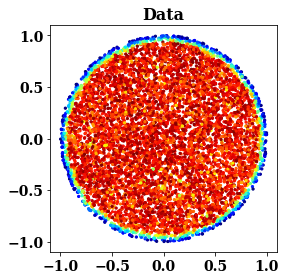

In [25]:
vis.data(X, bx)

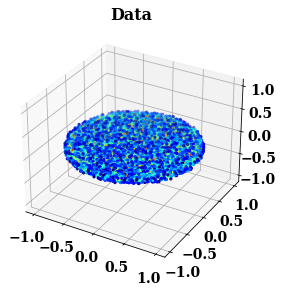

In [28]:
vis.data(X_noise, bx_noise)

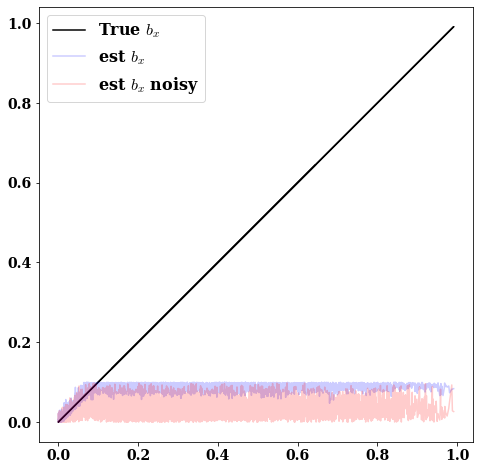

In [34]:
plt.figure(figsize=(8,8))
ind = np.argsort(ddX)
plt.plot(ddX, ddX, color='k', label='True $b_x$')
plt.plot(ddX[ind], bx[ind], color='b', label='est $b_x$', alpha=0.2)
plt.plot(ddX_noise[ind], bx_noise[ind], color='r', label='est $b_x$ noisy', alpha=0.2)
plt.axis('image')
plt.legend()